# Training Set

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

### Read raw training data

In [19]:
amazon = pd.read_csv('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/amazon_data/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [20]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      161979        251062  251063  B002INDU22  A16M0DLZ493518   
1       72164        206109  206110  B0050JLAEQ  A2B940BLM1T0V3   
2      452002        334972  334973  B003D4MW38  A2I8UYFVJ5TLHT   
3      419090        119275  119276  B003Z7VYXW  A1YC6AYVXK7NRQ   
4      304509         90726   90727  B003OB4BOS  A29NOSP1RGTQNK   

         ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0            do-good                     0                       0      4   
1              donna                     0                       0      5   
2         greenie227                     1                       1      5   
3  DesDaz "torr0015"                     2                       2      5   
4               Josh                     0                       0      4   

         Time                           Summary  \
0  1331337600                             Works   
1  1348617600    She loves, it, 

In [21]:
from gensim.parsing.preprocessing import remove_stopwords
# remove stop words in amazon.Text
amazon['Text'] = amazon['Text'].apply(remove_stopwords)
#newText = amazon['Text'].apply(remove_stopwords)
print(amazon.Text)
#print(newText)

import nltk
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

#Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

print(amazon['Text'][0])
print(lemmatizer.lemmatize(amazon['Text'][0]))

#gensim lemmatize needs pattern, but it is only support python 3.6 below
# from gensim.utils import lemmatize
# amazon['Text'] = amazon['Text'].apply(lemmatize)

# leText=newText.apply(lemmatizer.lemmatize)
print(lemmatizer.lemmatize("my bats"))


0         We tried I worried work. They work well. My fa...
1         My vet recommended 11 year old cat change diet...
2         This terrific tea. I bought iced tea, it's got...
3         I excellent results yeast. When I opened packa...
4         I wasn't disappointed, enjoys spicy food 'pica...
5         My mom Bustelo cafe like old neighborhood. One...
6         I tried samples liked them. However, I tried c...
7         I discovered sweetener couple months ago huge ...
8         Rooibos tea great healing skin conditions it's...
9         I use Kretschmer Wheatgerm homemade granola re...
10        These best hazelnuts I've years. They fresh, c...
11        I Jamba Juice Match green tea shots...after tr...
12        These black ink black we're seeing canned blac...
13        I highly recommend these. They tasted great! I...
14        I bought package 10 month old practice self fe...
15        I bought thinking taste like peppermint patty,...
16        I buy 2 packs daily $5 pack. W

### Feature extraction on natural language data

In [174]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())


In [17]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
#X_hv = hv.fit_transform(newText)
print(hv)
print(X_hv.shape)

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=131072, ngram_range=(1, 1), non_negative=True,
         norm='l2', preprocessor=None, stop_words=None, strip_accents=None,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None)
(364000, 131072)


In [176]:
type(X_hv)

scipy.sparse.csr.csr_matrix

In [177]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [178]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [179]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [180]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      4        281
1      5        277
2      5         72
3      5        202
4      4        121
5      5        118
6      5        105
7      5        563
8      5       1034
9      5        452
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [181]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131074)


In [182]:
# look at an example of a "row" of a sparse matrix
print(X_matrix[1234])

  (0, 1396)	0.09755261490953315
  (0, 5744)	0.16638612402007336
  (0, 10127)	0.08443194607741517
  (0, 12360)	0.05783585825663549
  (0, 17096)	0.06896310384382182
  (0, 17958)	0.07172985062868213
  (0, 21662)	0.07109296531984213
  (0, 22561)	0.08558974888148561
  (0, 24734)	0.033805360346365824
  (0, 26415)	0.10709889239675342
  (0, 27286)	0.08178832420225421
  (0, 30217)	0.1077808934665522
  (0, 30587)	0.057280529614282774
  (0, 32689)	0.06542662187631546
  (0, 35400)	0.07205254404218642
  (0, 35440)	0.08000867214349118
  (0, 36281)	0.06572618732914116
  (0, 37771)	0.09939554784969735
  (0, 38990)	0.07042979001691516
  (0, 39731)	0.07342879847902052
  (0, 41642)	0.04390040440755441
  (0, 42257)	0.0600498075272038
  (0, 47468)	0.08178512084118028
  (0, 51635)	0.06192384381349832
  (0, 52237)	0.13712169383362013
  :	:
  (0, 103968)	0.09152392641743488
  (0, 106191)	0.07053060777258889
  (0, 106475)	0.09215930455613514
  (0, 107760)	0.1133030723578394
  (0, 109683)	0.09015316279709543
  

### Create `X`, scaled matrix of features

In [183]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131074)


['sc.pkl']

### create `y`, vector of Labels

In [184]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


# fit models

In [185]:
from my_measures import BinaryClassificationPerformance

### MODEL: ordinary least squares

In [186]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X, y)
joblib.dump(ols, 'ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

{'Pos': 26628, 'Neg': 337372, 'TP': 12496, 'TN': 185105, 'FP': 152267, 'FN': 14132, 'Accuracy': 0.5428598901098901, 'Precision': 0.07584227041265333, 'Recall': 0.4692804566621601, 'desc': 'ols'}


### MODEL: SVM, linear

In [187]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 26628, 'Neg': 337372, 'TP': 12436, 'TN': 322529, 'FP': 14843, 'FN': 14192, 'Accuracy': 0.9202335164835165, 'Precision': 0.4558818138494813, 'Recall': 0.46702718942466576, 'desc': 'svm'}


### MODEL: logistic regression

In [200]:
from sklearn import linear_model
from tqdm import tqdm

#for alpha in range(0.1, 1.0, 0.1):  #range只能取整数
#tAlpha= np.linspace(0,1,11)
#lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=alpha)

# for alpha in np.linspace(0.0012,0.003,5):
#     lgs = linear_model.SGDClassifier(loss='log', max_iter=50, alpha=alpha) # default alpha= 0.00001   测试到5
lgs = linear_model.SGDClassifier(loss='log', max_iter=100, alpha=0.001572)# default alpha= 0.00001   测试到5
# lgs = linear_model.SGDClassifier(loss='log', max_iter=100, alpha=0.00165)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle
lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)
# print(alpha)

{'Pos': 26628, 'Neg': 337372, 'TP': 12229, 'TN': 335616, 'FP': 1756, 'FN': 14399, 'Accuracy': 0.9556181318681318, 'Precision': 0.8744368966750089, 'Recall': 0.4592534174553102, 'desc': 'lgs'}


### MODEL: Naive Bayes

In [112]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26628, 'Neg': 337372, 'TP': 17394, 'TN': 294176, 'FP': 43196, 'FN': 9234, 'Accuracy': 0.8559615384615384, 'Precision': 0.2870770754249876, 'Recall': 0.653222172149617, 'desc': 'nbs'}


### MODEL: Perceptron

In [113]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26628, 'Neg': 337372, 'TP': 12579, 'TN': 322092, 'FP': 15280, 'FN': 14049, 'Accuracy': 0.9194258241758242, 'Precision': 0.45152374457087474, 'Recall': 0.472397476340694, 'desc': 'prc'}


### MODEL: Ridge Regression Classifier

In [114]:
from sklearn import linear_model
from tqdm import tqdm

#for NumberRRC in tqdm(np.linspace(0.0,1,10)):
rdg = linear_model.RidgeClassifier(alpha=5)
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)
#print (NumberRRC)

{'Pos': 26628, 'Neg': 337372, 'TP': 8086, 'TN': 336715, 'FP': 657, 'FN': 18542, 'Accuracy': 0.9472554945054945, 'Precision': 0.9248541690495253, 'Recall': 0.3036653147063242, 'desc': 'rdg'}


In [115]:
rdg.get_params()

{'alpha': 5,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

### What is the distribution of weights, OLS vs. ridge? 

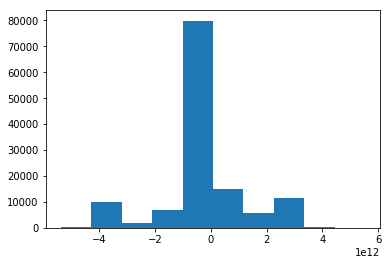

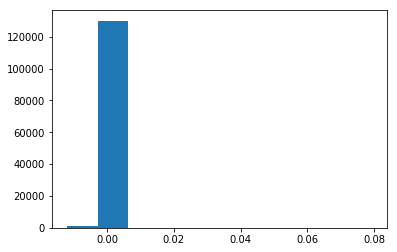

In [116]:
plt.hist(ols.coef_[0])
plt.show()

plt.hist(rdg.coef_[0])
plt.show()

### MODEL: Decision Tree Classifier

In [117]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(max_depth=100)
dtc.fit(X_matrix, y)
joblib.dump(dtc, 'dtc.pkl') # pickle

dtc_performance = BinaryClassificationPerformance(dtc.predict(X_matrix), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 26628, 'Neg': 337372, 'TP': 9716, 'TN': 337343, 'FP': 29, 'FN': 16912, 'Accuracy': 0.9534587912087912, 'Precision': 0.9970241149307337, 'Recall': 0.3648790746582545, 'desc': 'dtc'}


### ROC plot to compare performance of various models and fits

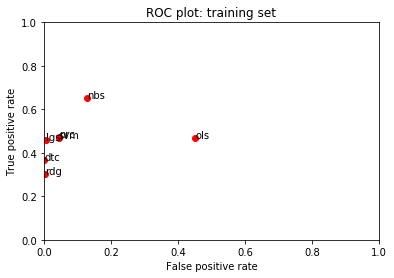

In [201]:
fits = [svm_performance, lgs_performance, rdg_performance, prc_performance, ols_performance, dtc_performance, nbs_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## a digression: looking inside the `rdg` object

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [119]:
dir(rdg)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_label_binarizer',
 '_predict_proba_lr',
 '_preprocess_data',
 '_set_intercept',
 'alpha',
 'class_weight',
 'classes_',
 'coef_',
 'copy_X',
 'decision_function',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'max_iter',
 'n_iter_',
 'normalize',
 'predict',
 'random_state',
 'score',
 'set_params',
 'solver',
 'tol']

In [34]:
rdg.get_params()

{'alpha': 5,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [35]:
type(rdg.coef_)

numpy.ndarray

In [36]:
rdg.coef_.shape

(1, 131074)

In [37]:
print(rdg.coef_[0])

[-0.00183324 -0.00018589  0.         ... -0.00044401  0.00266334
  0.07976268]


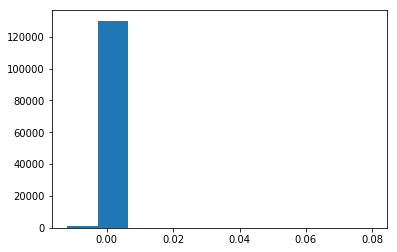

In [38]:
plt.hist(rdg.coef_[0])
plt.show()

# looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [39]:
amazon.loc[0, "Text"]

'We tried these and I was worried that they may not work. They did work well. My family has loved trying them. We even enjoyed our lunch salad no dressing with just fruit and greek yogurt all natural. Tasty.<br />The pill was hard and took a few moments to melt but it worked right away.  It lasted for 20-25 minutes of active eating. I think the acid in the sour foods washes it away. I would try it again.'

In [40]:
amazon.loc[0, "helpful"]

False

In [41]:
ridge_predictions = rdg.predict(X)

In [42]:
ridge_predictions.shape

(364000,)

In [43]:
print(ridge_predictions)

[False False False ...  True False False]


In [44]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')

11142
2012-10-18 00:00:00
5
0
B009L47BR6
Best tea is grown in Sri Lanka and wanted to get this tea in US for a long time. I did not know this tea was actually from Sri Lanka and was surprised to find that it.<br /><br />Anyway, tea is superb. Would strongly recommend it.
* * * * * * * * * 
15184
2009-11-01 00:00:00
2
1
B00315WGNK
I ordered this product because it was described as "all-natural with no chemical preservatives" and the gold box price price was good.  It arrived quickly, as usual for Amazon, and it tastes good.  But, it's not "all-natural with no chemical preservatives" unless you consider sodium nitrite and partially hydrogenated vegetable oil to fall under that description.  I would consider ordering it again if it weren't for the artificial ingredients.<br /><br />How do they get away with suggesting that there are no artificial preservatives (sodium nitrite) in this stuff?  Sodium nitrite has been linked to migraines and colon cancer and has been used as a poison in lar

101487
2008-11-17 00:00:00
4
4
B000PDO2YC
Tasty. I get a little gas afterwards though : )<br />Also, it says vegetal, but there's meat in it (if you care).
* * * * * * * * * 
101901
2009-09-22 00:00:00
4
3
B002AR158W
I am a great fan of greens and oolongs, particularly scented teas.<br /><br />This puerh brews deep reddish-brown liquor.  It is a full-bodied, smooth tea.  It has a light, not overbearing floral scent and a bold, but slightly sweet, fruity taste and a somewhat astringent finish.<br /><br />I do not taste the green except in the finish.  In fact, I wondered at first if there actually was green tea in the blend.  I was also interested in what is in the teabag, so I opened one to examine it.  There is indeed green tea in it.  The teabag does not contain tea dust.  It contains fannings, which are pieces of broken leaf.<br />I have added photos so you can see the liquor and the contents of the teabag.<br /><br />You can drink this pleasant tea unadorned if you wish.  It is a g

247023
2012-04-21 00:00:00
5
0
B000VNNSEG
Another of my favorite honeys.  This is from New Zealand, also made from the leatherwood flower.  It's a little thicker than the one from Australia, but not quite as sweet.  Delicious over Greek yogurt.
* * * * * * * * * 
260714
2012-01-07 00:00:00
1
2
B0053TENTW
!!! PRODUCT HAS NOTHING TO DO WITH MARVEL!!! FALSE ADVERTISEMENT!!!  WASTE OF MONEY! IF I WANTED REGULAR BUBBLE GUM TAPE FOR MY SON'S SUPERHERO THEME PARTY I WOULDVE WENT TO DOLLAR STORE OR WALMART!<a href="http://www.amazon.com/gp/product/B0053TENTW">Marvel Heroes Crazy Rollz Gum, 24 count</a>
* * * * * * * * * 
278510
2011-08-08 00:00:00
2
0
B001M0G2Q8
Paid $33 total for this product, as I was interested in getting at little fat as possible since my wife was doing the hcg diet. But all in all, the .5g of fat you save per tbsp isn't worth the jacked up price for this cocoa. Also, the tin cans they come in are VERY messy, and for one the container swelled shut, and in the process of ca